# Classification

In [77]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.base import BaseEstimator
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets

# MNIST dataset

In [23]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [24]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [25]:
y = y.astype(float)
y

array([5., 0., 4., ..., 4., 5., 6.])

In [26]:
y_,idx=np.unique(y,return_index=True)
y_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

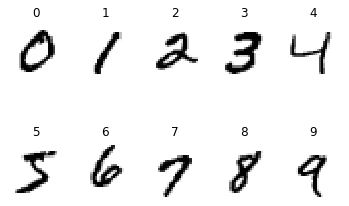

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=5)

count=0
for row in ax:
    for col in row:
        col.imshow(X[idx[count]].reshape(28,28),cmap = mpl.cm.gray_r)
        col.axis('off')
        col.set_title(count)
        count+=1

In [28]:
x_train, x_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

## A Binary classifier

In [29]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [30]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_5)
y_pred_5 = sgd_clf.predict(x_test)
print("Prediction accuracy: ", metrics.accuracy_score(y_test_5,y_pred_5))

Prediction accuracy:  0.9492


A K-fold cross validation:

In [31]:
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

But is the random random? Try using StratifiedKfold:

In [32]:
skfolds = StratifiedKFold(n_splits = 3,random_state=42)

fold = 0
for train_idx, test_idx in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)
    x_train_fold = x_train[train_idx]
    y_train_fold = y_train_5[train_idx]
    x_test_fold = x_train[test_idx]
    y_test_fold = y_train_5[test_idx]
    clone_clf.fit(x_train_fold, y_train_fold)
    y_pred_fold = clone_clf.predict(x_test_fold)
    print("Accuracy of fold {} : {}\n" .format(fold+1, metrics.accuracy_score(y_test_fold, y_pred_fold)))
    fold+=1
    

Accuracy of fold 1 : 0.95035

Accuracy of fold 2 : 0.96035

Accuracy of fold 3 : 0.9604



So it uses StratifiedKfold !

In [33]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [34]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

The target 5 is low (about 10% ). Accuracy is not a good measure. Confusion matrix -

In [35]:
y_train_pred = model_selection.cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [36]:
metrics.confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [37]:
metrics.precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [38]:
metrics.recall_score(y_train_5, y_train_pred)

0.6511713705958311

When it claims an image represents a 5, it is correct only 83.7% of the time.
It only detects 65.12% of the 5s.

Harmonics mean of these two - F1 score

In [39]:
metrics.f1_score(y_train_5, y_train_pred)

0.7325171197343846

This favors models with similar precision and recall.

### Precision/Recall trade off

In [40]:
y_scores = sgd_clf.decision_function(X[0].reshape(1,-1))
y_scores

array([2164.22030239])

In [41]:
threshold = 0 # default
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [42]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Raising threshold increases recall !

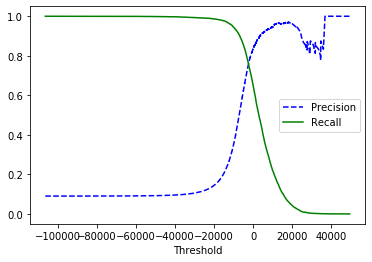

In [43]:
y_scores = model_selection.cross_val_predict(sgd_clf, x_train, y_train_5, cv=3,method="decision_function")
precisions, recalls, thresholds = metrics.precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
   # highlight the threshold, add the legend, axis label and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.xlabel('Threshold')
plt.show()

No handles with labels found to put in legend.


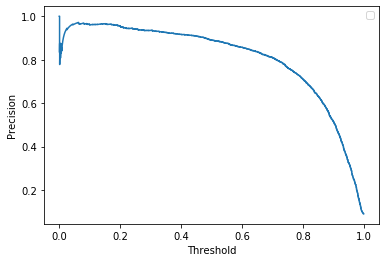

In [44]:
plt.plot(recalls,precisions)
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

In [45]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [46]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(metrics.precision_score(y_train_5, y_train_pred_90))
print(metrics.recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


High Precision is not always good !

In [47]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_5, y_scores)

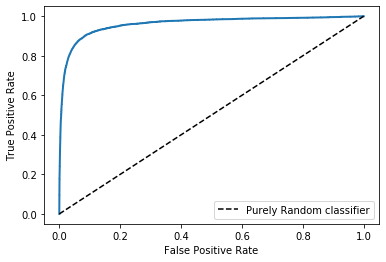

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Purely Random classifier') # dashed diagonal
    # Add axis labels and grid
plot_roc_curve(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [49]:
metrics.roc_auc_score(y_train_5, y_scores)

0.9604938554008616

G:\Anaconda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
G:\Anaconda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


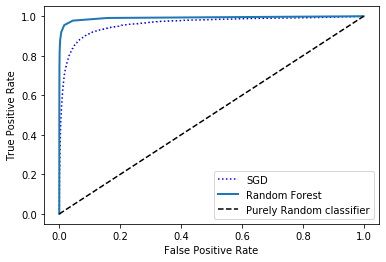

In [50]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = model_selection.cross_val_predict(forest_clf, x_train, y_train_5, cv=3,method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = metrics.roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [51]:
metrics.roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [52]:
print(metrics.precision_score(y_train_5,np.argmax(y_probas_forest, axis=1)))
print(metrics.recall_score(y_train_5, np.argmax(y_probas_forest, axis=1)))

0.986046511627907
0.8212506917542889


## Multiclass classification


Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass
classification task, and it automatically runs OvA

In [53]:
sgd_clf.fit(x_train, y_train) # y_train, not y_train_5
sgd_clf.predict(x_train[0].reshape(1,-1))

array([3.])

In [54]:
some_digit_scores = sgd_clf.decision_function(x_train[0].reshape(1,-1))
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [55]:
np.argmax(some_digit_scores)

3

In [56]:
sgd_clf.classes_

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

Alternatively, to run OvO instead of OvA:

In [57]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(x_train, y_train)
ovo_clf.predict(x_train[0].reshape(1,-1))
len(ovo_clf.estimators_)

45

In [58]:
forest_clf.fit(x_train, y_train)
forest_clf.predict(x_train[0].reshape(1,-1))

G:\Anaconda\envs\tensorflow_cpu\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5.])

In [59]:
forest_clf.predict_proba(x_train[0].reshape(1,-1))

array([[0. , 0. , 0. , 0.2, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [60]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [61]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

G:\Anaconda\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

In [62]:
y_train_pred = model_selection.cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = metrics.confusion_matrix(y_train, y_train_pred)
conf_mx

G:\Anaconda\envs\tensorflow_cpu\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

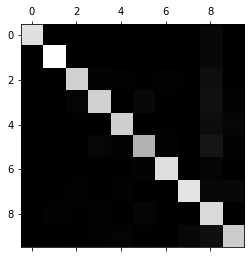

In [63]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [64]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

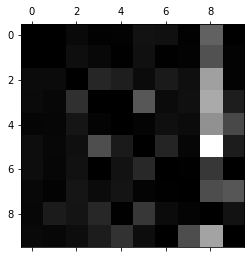

In [65]:
np.fill_diagonal(norm_conf_mx, 0) # fill diag with 0 only to keep error
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

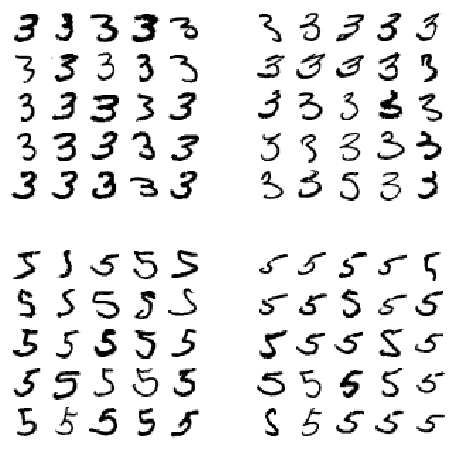

In [66]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(x_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(x_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(x_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(x_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classifiers

In [68]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [69]:
knn_clf.predict(x_train[0].reshape(1,-1))

array([[False,  True]])

In [73]:
y_train_knn_pred = model_selection.cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
metrics.f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## Multi-output Classifiers

In [74]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

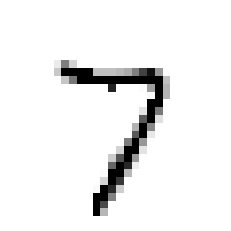

In [76]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

    knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[0]])
plot_digit(clean_digit)